# Fine-Tuning de LLMs com QLoRA e Unsloth
## Mestrado em Ciência da Computação - IC/UFMT
**Disciplina:** Tópicos Avançados em Inteligência Artificial
**Alunos: ** Matheus Cândido Teixeira e Rodrigo de Souza Oliveira

**Objetivo:** Comparar estratégias de adaptação (Zero-Shot, Last Layer, Full LoRA) na tarefa de geração de títulos a partir de resumos.

**Modelo:** Qwen2.5-0.5B-Instruct

In [1]:
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.7/358.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.4/284.4 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: torchao
    Found existing installation: torchao 0.10.0
    Uninstalling torchao-0.10.0:
      

In [45]:
import os

# Passo 1: Selecionar o tipo de experimento
# --- SELECIONE O EXPERIMENTO AQUI ---
# Opções: "baseline", "last_layer", "full_lora"
TIPO_EXPERIMENTO = "full_lora"
# ------------------------------------

print(f"Configurando ambiente para o experimento: {TIPO_EXPERIMENTO.upper()}")

# Parâmetros Globais
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
MAX_SEQ_LENGTH = 2048
OUTPUT_DIR = f"./output_{TIPO_EXPERIMENTO}"

Configurando ambiente para o experimento: FULL_LORA


In [46]:
import torch
from unsloth import FastLanguageModel

# Passo 2: Carregar o modelo e tokenizer com Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME,
    max_seq_length = MAX_SEQ_LENGTH,
    dtype = None,
    load_in_4bit = True,
)

==((====))==  Unsloth 2025.11.4: Fast Qwen2 patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [47]:
# Passo 3: Configura os adaptadores quando não for baseline
if TIPO_EXPERIMENTO != "baseline":

    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    layers_to_transform = None

    # Lógica para a última camada
    if TIPO_EXPERIMENTO == "last_layer":
        n_layers = len(model.model.layers)
        layers_to_transform = [n_layers - 1]
        print(f"Congelando camadas iniciais. Treinando apenas a camada {n_layers - 1}.")

    model = FastLanguageModel.get_peft_model(
        model,
        r = 16,
        lora_alpha = 32,
        lora_dropout = 0.05,
        bias = "none",
        use_gradient_checkpointing = "unsloth",
        random_state = 42,
        target_modules = target_modules,
        layers_to_transform = layers_to_transform,
    )
    print(f"Adaptadores LoRA aplicados para: {TIPO_EXPERIMENTO}")
else:
    print("Modo Baseline: Nenhum adaptador LoRA aplicado. Usando modelo original.")

Adaptadores LoRA aplicados para: full_lora


In [48]:
# Passo 4: Configura os datasets
import pandas as pd
from datasets import Dataset

CAMINHO_TREINO = "/content/supervised_data.json"
CAMINHO_TESTE = "/content/test_data.json"

EOS_TOKEN = tokenizer.eos_token
if not EOS_TOKEN: EOS_TOKEN = "<|endoftext|>"

def format_prompt(exemplo):
    prompt = (
        "<|im_start|>system\n"
        "You are a specialist in suggesting titles based on the abstract.<|im_end|>\n"
        "<|im_start|>user\n"
        f"{exemplo['abstract']}<|im_end|>\n"
        "<|im_start|>assistant\n"
        f"{exemplo['title']}{EOS_TOKEN}"
    )
    return {"text": prompt}

if os.path.exists(CAMINHO_TREINO):
    df_train = pd.read_json(CAMINHO_TREINO, lines=True)
    ds_train = Dataset.from_pandas(df_train)
    ds_train = ds_train.map(format_prompt)
    print(f"Dados de treino carregados: {len(df_train)} exemplos.")
else:
    print("Arquivo de treino não encontrado")

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Dados de treino carregados: 201 exemplos.


In [49]:
# Passo 5: Treinamento
from trl import SFTTrainer
from transformers import TrainingArguments

if TIPO_EXPERIMENTO != "baseline":
    print("Iniciando Treinamento...")

    trainer = SFTTrainer(
        model = model,
        tokenizer = tokenizer,
        train_dataset = ds_train,
        dataset_text_field = "text",
        max_seq_length = MAX_SEQ_LENGTH,
        dataset_num_proc = 2,
        packing = False,
        args = TrainingArguments(
            per_device_train_batch_size = 2,
            gradient_accumulation_steps = 4,
            warmup_steps = 10,
            num_train_epochs = 3,
            learning_rate = 2e-4,
            fp16 = not torch.cuda.is_bf16_supported(),
            bf16 = torch.cuda.is_bf16_supported(),
            logging_steps = 10,
            optim = "adamw_8bit",
            weight_decay = 0.01,
            lr_scheduler_type = "linear",
            seed = 42,
            output_dir = OUTPUT_DIR,
            report_to = "none",
        ),
    )

    trainer_stats = trainer.train()
    print("Treinamento Concluído!")
else:
    print("Pulando etapa de treinamento (Modo Baseline).")

Iniciando Treinamento...


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/201 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 201 | Num Epochs = 3 | Total steps = 78
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 8,798,208 of 502,830,976 (1.75% trained)


Step,Training Loss
10,3.135400
20,2.524400
30,2.364200
40,2.301400
50,2.294800
60,2.084500
70,2.161900


Treinamento Concluído!


In [50]:
# Passo 6: Inferência e métricas.
from sentence_transformers import SentenceTransformer
import numpy as np

FastLanguageModel.for_inference(model)

def gerar_titulos(abstracts):
    titulos_gerados = []
    system_prompt = "You are a specialist in suggesting titles based on the abstract."

    for abstract in abstracts:
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": abstract}
        ]

        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to("cuda")

        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=64,
            use_cache=True,
            pad_token_id=tokenizer.eos_token_id
        )

        decoded = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
        titulos_gerados.append(decoded.strip())

    return titulos_gerados

def avaliar_similaridade(abstracts, titulos_reais, titulos_preditos):
    device_eval = "cuda" if torch.cuda.is_available() else "cpu"
    bert_model = SentenceTransformer("all-MiniLM-L6-v2", device=device_eval)

    emb_pred = bert_model.encode(titulos_preditos, convert_to_tensor=True)
    emb_real = bert_model.encode(titulos_reais, convert_to_tensor=True)

    similarities = bert_model.similarity(emb_pred, emb_real).diag().cpu().numpy()

    return similarities

if os.path.exists(CAMINHO_TESTE):
    df_test = pd.read_json(CAMINHO_TESTE, lines=True)
    # df_test = df_test.head(5)

    print(f"Iniciando inferencia em {len(df_test)} exemplos...")
    predicoes = gerar_titulos(df_test['abstract'].tolist())
    scores = avaliar_similaridade(df_test['abstract'].tolist(), df_test['title'].tolist(), predicoes)

    df_resultado = pd.DataFrame({
        "Abstract": df_test['abstract'],
        "Titulo_Real": df_test['title'],
        "Titulo_Predito": predicoes,
        "Score": scores,
        "Experimento": TIPO_EXPERIMENTO
    })

    nome_arquivo = f"resultados_{TIPO_EXPERIMENTO}.csv"
    df_resultado.to_csv(nome_arquivo, index=False)

    print(f"Resultados salvos em: {nome_arquivo}")
    print(f"Média SBERT: {scores.mean():.4f}")
else:
    print("Arquivo de teste não encontrado.")

Iniciando inferencia em 100 exemplos...
Resultados salvos em: resultados_full_lora.csv
Média SBERT: 0.6118


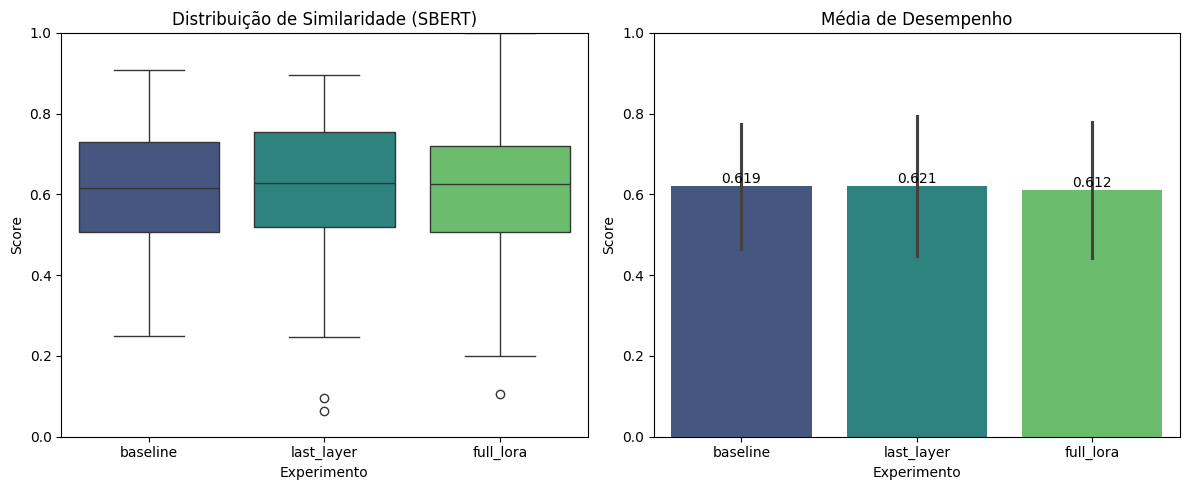


=== Tabela Resumo ===
             count      mean       std       min       max
Experimento                                               
baseline       100  0.619420  0.154201  0.248278  0.907475
full_lora      100  0.611811  0.168412  0.105352  1.000000
last_layer     100  0.621061  0.173758  0.063931  0.896461


In [51]:
# Passo 7: Avaliação | RODAR SOMENTE APÓS RODAS OS 3 EXPERIMENTOS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

arquivos_csv = glob.glob("resultados_*.csv")

if not arquivos_csv:
    print("Nenhum arquivo de resultado encontrado. Rode os experimentos primeiro.")
else:
    df_final = pd.concat([pd.read_csv(f) for f in arquivos_csv], ignore_index=True)

    ordem = ["baseline", "last_layer", "full_lora"]
    ordem = [x for x in ordem if x in df_final['Experimento'].unique()]

    plt.figure(figsize=(12, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x="Experimento", y="Score", data=df_final, order=ordem, palette="viridis")
    plt.title("Distribuição de Similaridade (SBERT)")
    plt.ylim(0, 1)

    # Grafico de barras
    plt.subplot(1, 2, 2)
    barplot = sns.barplot(x="Experimento", y="Score", data=df_final, order=ordem, palette="viridis", errorbar="sd")
    plt.title("Média de Desempenho")
    plt.ylim(0, 1)
    for p in barplot.patches:
        if p.get_height() > 0:
            barplot.annotate(f'{p.get_height():.3f}',
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    print("\n ------ Tabela com Estatísticas de resumo ------ "
    resumo = df_final.groupby("Experimento")["Score"].agg(['count', 'mean', 'std', 'min', 'max'])
    print(resumo)